In [17]:
import json
from shapely.ops import cascaded_union
from rasterio.plot import plotting_extent
import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
import os

In [6]:
path = os.getcwd()

In [7]:
path

'/Users/user/Documents/GitHub/canopy-gis/processing'

In [8]:
df_labels = pd.read_csv("/Users/user/Documents/GitHub/canopy-gis/data_collection/data/labelled/labels_Misha_v2.csv")
df_labels = df_labels[["center-lat","center-long","polygon"]][0:33]

In [71]:
polygons = []
for polygon in df_labels["polygon"]:
    polygon_temp = []
    for coordinates in json.loads(polygon)["coordinates"]:
        for coordinate in coordinates:
            polygon_temp.append(tuple(coordinate))
        polygons.append(Polygon(polygon_temp))


In [83]:
boundary = gpd.GeoSeries(cascaded_union(polygons))

<AxesSubplot:>

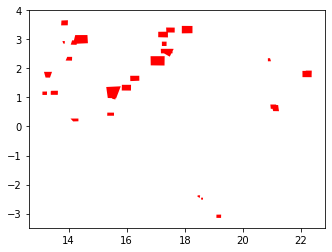

In [84]:
boundary.plot(color = 'red')

In [86]:
boundary

0    MULTIPOLYGON (((19.09029 -3.03715, 19.25251 -3...
dtype: geometry

In [87]:
boundary.to_file("/Users/user/Documents/GitHub/canopy-gis/data_collection/data/labelled/labels_v1.shp")

# Crop Raster from Polygon

In [33]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
# import cartopy as cp

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
test_raster = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Test/MISC/Test_w_shape_file.tif"
test_shape = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/test_polygon_extraction/test.shp"

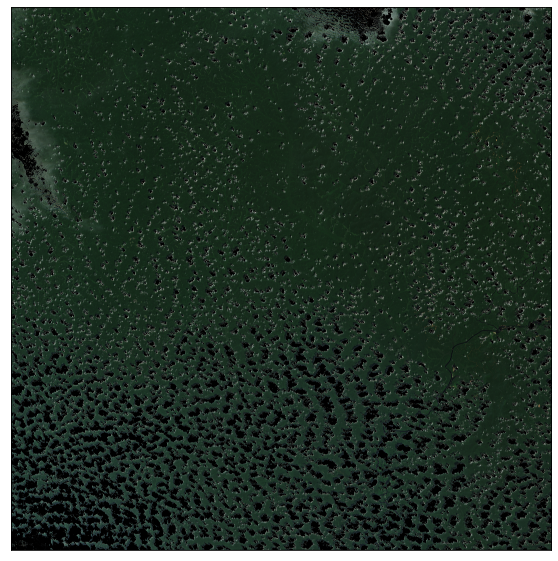

In [39]:
with rio.open(test_raster) as src:
    lidar_chm_im = src.read()
    extent = rio.plot.plotting_extent(src)
    soap_profile = src.profile

ep.plot_rgb(lidar_chm_im)
plt.show()

In [98]:
crop_extent_soap = gpd.read_file(test_shape)

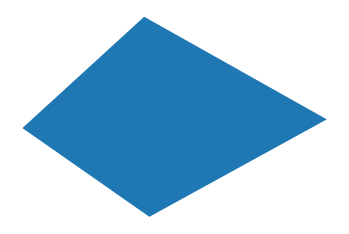

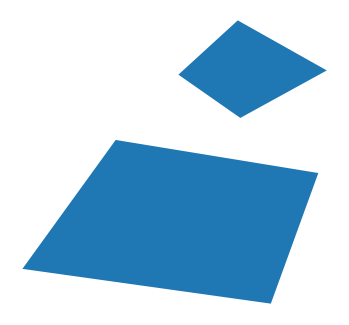

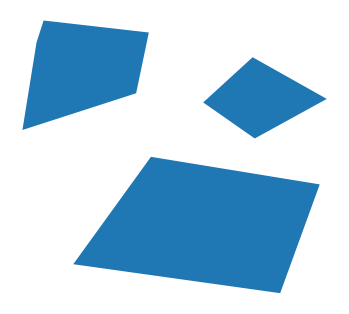

In [118]:
for index in range(1,crop_extent_soap.shape[0]+1):
    crop_extent = crop_extent_soap.head(index)
    
    # plot the data
    fig, ax = plt.subplots(figsize = (6, 6))
    crop_extent.plot(ax=ax)
    ax.set_axis_off();

In [88]:
crop_extent_soap = crop_extent_soap.head(1)

In [89]:
print('crop extent crs: ', crop_extent_soap.crs)
print('lidar crs: ', soap_profile['crs'])

crop extent crs:  epsg:4326
lidar crs:  EPSG:4326


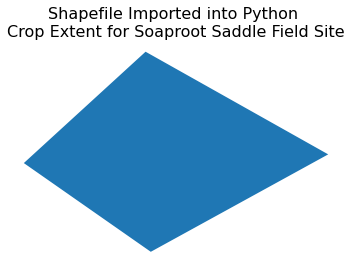

In [91]:
# plot the data
fig, ax = plt.subplots(figsize = (6, 6))
crop_extent_soap.plot(ax=ax)
ax.set_title("Shapefile Imported into Python \nCrop Extent for Soaproot Saddle Field Site", 
             fontsize = 16)
ax.set_axis_off();

In [92]:
crop_extent_soap.head(1)

,id,geometry
0,1.0,"POLYGON ((12.88218 1.46884, 12.98648 1.41023, ..."


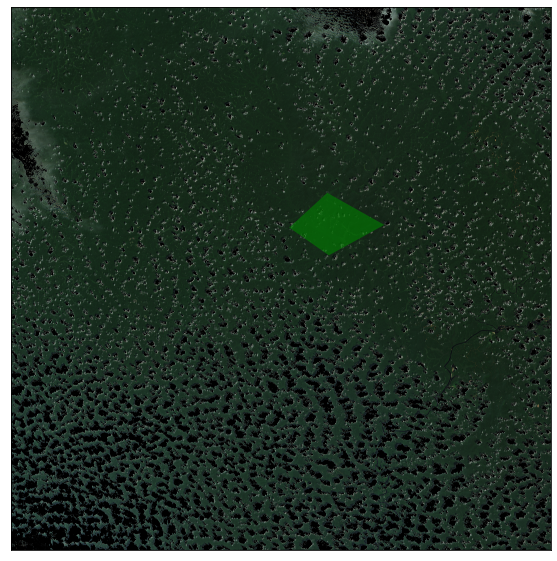

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_rgb(lidar_chm_im,
              extent=extent,
              ax=ax)
crop_extent_soap.plot(ax=ax, alpha=.6, color='g');

In [94]:
crop_extent_soap

,id,geometry
0,1.0,"POLYGON ((12.88218 1.46884, 12.98648 1.41023, ..."


In [95]:
with rio.open(test_raster) as src:
    lidar_chm_crop, soap_lidar_meta = es.crop_image(src, crop_extent_soap)

In [96]:
# Update the metadata to have the new shape (x and y and affine information)
soap_lidar_meta.update({"driver": "GTiff",
                 "height": lidar_chm_crop.shape[0],
                 "width": lidar_chm_crop.shape[1],
                 "transform": soap_lidar_meta["transform"]})

# generate an extent for the newly cropped object for plotting
cr_ext = rio.transform.array_bounds(soap_lidar_meta['height'], 
                                            soap_lidar_meta['width'], 
                                            soap_lidar_meta['transform'])

bound_order = [0,2,1,3]
cr_extent = [cr_ext[b] for b in bound_order]
cr_extent, crop_extent_soap.total_bounds

([12.81260764059288,
  12.926962410267457,
  1.4686467943308843,
  1.4689171365760543],
 array([12.8126404 ,  1.3546062 , 12.98647782,  1.46884222]))

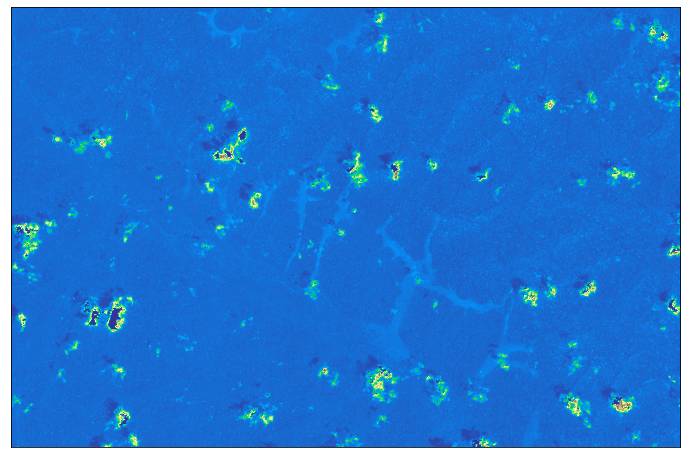

In [97]:
# mask the nodata and plot the newly cropped raster layer
lidar_chm_crop_ma = np.ma.masked_equal(lidar_chm_crop[0], -9999.0) 
ep.plot_bands(lidar_chm_crop_ma, cmap='terrain', cbar=False);